# CNN for Classification
### Load the data

In [1]:
# our basic libraries
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir(r'C:\Users\atavares\PycharmProjects\ComputerVision')

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms



# The output of torchvision dataset are PILimage images of range [0, 1]
# We transform them to Tersors for input into a CNN

## Define a transform to read the data in as ternsor
data_transform = transforms.ToTensor()

# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True, download=False,
                          transform=data_transform)

test_data = FashionMNIST(root='./data', train=False, download=False,
                         transform=data_transform)
# Print out some stats about the training data
print(f'Train data, number of images: { len(train_data)}')
print(f'Test data, number of images: { len(test_data)}')

Train data, number of images: 60000
Test data, number of images: 10000


### Data iteration and batching
We'll use torch.utils.data.DataLoader, which is an iterator that allows
us to batch and shuffle data.

In [2]:
# prepare data loaders, set the batch_size

batch_size= 20
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize some training data
This cell iterates over the training dataset, loading a random batch of image
label data, using dataiter.next(). It then plots the batch of images and labels
in a 2x 2 batch_size.2 grid.

<ipython-input-3-1f347a8e88fe>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])


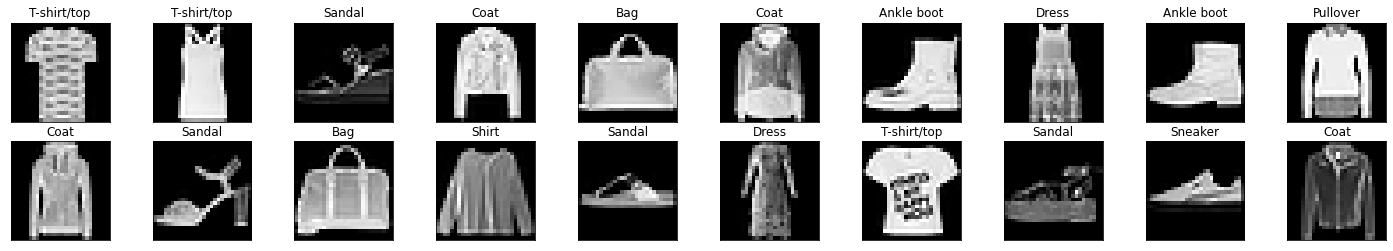

In [3]:
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

### Define the network architecture

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init()

        # 1 input image channel (grayscale), 10 output channels / feature maps
        # 3x3 square convolution kernel
        batch_size = 1
        self.conv1 = nn.Conv2d(batch_size,
                               in_channels=1,
                               out_channels=10,
                               kernel_size=3)
        batch_size = 1

        self.maxpool2d = nn.MaxPool2d(kernel_size=2,
                                      stride=2
                                      )

        self.conv2 = nn.Conv2d(batch_size,
                               in_channels=10,
                               out_channels=10,
                               kernel_size=3)
        self.linear = nn.Linear()


#

